In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from PIL import Image
import numpy as np
import os

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [2]:
# custom loss function, taking into account the RGB values
# 효과는 크게 없었지만, 논리적으로는 맞는 부분인 것 같음.

from tensorflow.keras import backend as K

# Custom loss function that applies MSE specifically to RGB channels
def mse_rgb(y_true, y_pred):
    # y_true and y_pred are assumed to be in shape (batch_size, height, width, 3)
    return K.mean(K.square(y_true - y_pred), axis=-1)

In [3]:
# more pooling with stride instead of GAP2D

def build_model(input_shape, output_frames):
    """
    Builds a CNN-based encoder-decoder model for animation frame prediction.
    
    Parameters:
    input_shape (tuple): The shape of the input frame (height, width, channels).
    output_frames (int): The number of frames to generate as output.
    
    Returns:
    model: The compiled Keras model.
    """
    # Encoder
    encoder_input = layers.Input(shape=input_shape, name='encoder_input')
    
    # CNN layers to encode the first frame
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(encoder_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), strides=2, padding='same', activation='relu')(x)
    
    # Flatten the output of the convolutional layers
    x = layers.Flatten()(x)

    # Latent representation
    latent = layers.Dense(512, activation='relu', name='latent_vector')(x)

    # Decoder (generate multiple frames)
    decoder_output = layers.Dense(output_frames * input_shape[0] * input_shape[1] * input_shape[2], activation='sigmoid')(latent)
    
    # Reshape to the desired output shape (frames, height, width, channels)
    decoder_output = layers.Reshape((output_frames, input_shape[0], input_shape[1], input_shape[2]), name='decoder_output')(decoder_output)

    # Build and compile the model
    model = models.Model(encoder_input, decoder_output, name='frame_predictor_model')
    
    model.compile(optimizer='adam', loss=mse_rgb, metrics=['mae'])
    return model

In [4]:
# Define input shape for 128x128x3 images
input_shape = (128, 128, 3)  # Height, Width, Channels
output_frames = 9  # Number of frames to predict

# Build the model
model = build_model(input_shape, output_frames)

# Print model summary
model.summary()

2024-10-25 15:33:33.022520: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-10-25 15:33:33.022555: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-10-25 15:33:33.022561: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-10-25 15:33:33.023018: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-25 15:33:33.023243: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "frame_predictor_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 2

In [5]:
def process_sprite_data(sprite_sheet_paths, num_frames):
    """
    Processes sprite sheets and returns animation data without saving individual images.
    
    Parameters:
    sprite_sheet_paths (list): List of paths to the sprite sheet images.
    num_frames (int): Total number of frames (sprites) in the sprite sheet.
    
    Returns:
    X (numpy array): Array of input frames (first frame of each animation sequence).
    Y (numpy array): Array of output frames (remaining frames of each animation sequence).
    """
    # Initialize lists for input (X) and output (Y) frames
    X = []
    Y = []
    
    # Process each sprite sheet in the provided paths
    for i in range(len(sprite_sheet_paths)):
        sprite_sheet = Image.open(sprite_sheet_paths[i])
        
        # Get sprite sheet dimensions
        sheet_width, sheet_height = sprite_sheet.size
        
        # Calculate the width and height of each frame
        frame_width = sheet_width // num_frames
        frame_height = sheet_height  # Height of each frame is the same as the height of the sprite sheet
        
        # Loop through each frame in the sprite sheet
        for frame_num in range(num_frames):
            # Calculate the coordinates of the sprite in the sprite sheet
            left = frame_num * frame_width
            upper = 0
            right = left + frame_width
            lower = frame_height
            
            # Crop the sprite from the sprite sheet
            frame = sprite_sheet.crop((left, upper, right, lower))
            
            # Resize to 128x128 if needed and convert to RGB
            frame = frame.convert('RGB').resize((128, 128))
            
            # Normalize pixel values to [0, 1]
            frame_array = np.array(frame) / 255.0
            
            # Append the first frame to X and the remaining ones to Y
            if frame_num == 0:
                X.append(frame_array)  # The first frame goes into X
            else:
                if len(Y) <= i:  # Initialize the sublist for Y if necessary
                    Y.append([])
                Y[i].append(frame_array)  # Subsequent frames go into Y
    
    return np.array(X), np.array(Y)

sprite_sheet_paths = ['/Users/lofichill/Desktop/NIPA/a-yo-image/initial-experiments/tomato/image folder/City_men_1_10f/Walk.png',
                      '/Users/lofichill/Desktop/NIPA/a-yo-image/initial-experiments/tomato/image folder/City_men_2_10f/Walk.png',
                      '/Users/lofichill/Desktop/NIPA/a-yo-image/initial-experiments/tomato/image folder/City_men_3_10f/Walk.png',
                      '/Users/lofichill/Desktop/NIPA/a-yo-image/initial-experiments/tomato/image folder/Gangsters_1_10f/Walk.png',
                      '/Users/lofichill/Desktop/NIPA/a-yo-image/initial-experiments/tomato/image folder/Gangsters_2_10f/Walk.png',
                      '/Users/lofichill/Desktop/NIPA/a-yo-image/initial-experiments/tomato/image folder/Gangsters_3_10f/Walk.png'
                     ] 
num_frames = 10  # Number of frames in the sprite sheet
X, Y = process_sprite_data(sprite_sheet_paths, num_frames)

print(f"X shape: {X[1:].shape}")  # Should be (num_sequences, 128, 128, 3)
print(f"Y shape: {Y[1:].shape}")  # Should be (num_sequences, 9, 128, 128, 3)

X shape: (5, 128, 128, 3)
Y shape: (5, 9, 128, 128, 3)


In [6]:
type(X)

numpy.ndarray

In [7]:
# Train the model without the first example = X[1:], Y[1:]
model.fit(X, Y, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50


2024-10-25 15:33:34.868826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.2440 - mae: 0.4921 - val_loss: 0.2449 - val_mae: 0.4935
Epoch 2/50


2024-10-25 15:33:36.303922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 812ms/step - loss: 0.2438 - mae: 0.4920 - val_loss: 0.2440 - val_mae: 0.4926
Epoch 3/50
1/1 [==============================] - 1s 595ms/step - loss: 0.2429 - mae: 0.4910 - val_loss: 0.2365 - val_mae: 0.4848
Epoch 4/50
1/1 [==============================] - 1s 705ms/step - loss: 0.2354 - mae: 0.4833 - val_loss: 0.1787 - val_mae: 0.4194
Epoch 5/50
1/1 [==============================] - 1s 671ms/step - loss: 0.1779 - mae: 0.4181 - val_loss: 0.0276 - val_mae: 0.1458
Epoch 6/50
1/1 [==============================] - 1s 713ms/step - loss: 0.0287 - mae: 0.1466 - val_loss: 0.0092 - val_mae: 0.0174
Epoch 7/50
1/1 [==============================] - 1s 697ms/step - loss: 0.0120 - mae: 0.0212 - val_loss: 0.0124 - val_mae: 0.0193
Epoch 8/50
1/1 [==============================] - 1s 703ms/step - loss: 0.0152 - mae: 0.0232 - val_loss: 0.0143 - val_mae: 0.0204
Epoch 9/50
1/1 [==============================] - 1s 559ms/step - loss: 0.0166 - mae: 0.0238 - val_lo

In [8]:
refine_train = []

for i in range(X.shape[0]):
    predicted_frames = model.predict(np.expand_dims(X[i], axis=0))  # Add batch dimension
    predicted_frames = predicted_frames.squeeze()  # Remove the batch dimension if needed
    merged_frames = np.concatenate((np.expand_dims(X[i], axis=0), predicted_frames), axis=0)
    refine_train.append(np.expand_dims(merged_frames, axis=0))
    
# print(f"Predicted frames shape: {predicted_frames.shape}")  # Should be (9, 128, 128, 3)

# # Optionally, save the predicted frames or display them
# for i in range(predicted_frames.shape[0]):
#     frame = (predicted_frames[i] * 255).astype(np.uint8)  # Convert back to [0, 255]

1/1 [==============================] - 0s 15ms/step


2024-10-25 15:34:07.859268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 14ms/step


In [9]:
refine_train = np.concatenate(refine_train, axis=0) 
refine_train.shape

(6, 10, 128, 128, 3)

In [10]:
# def merge_frames(input_frame, output_frames):
#     """
#     Merge input_frame (1, 128, 128, 3) and output_frames (9, 128, 128, 3) into one array.
    
#     Parameters:
#     input_frame (numpy array): The first frame with shape (1, 128, 128, 3).
#     output_frames (numpy array): The rest of the frames with shape (9, 128, 128, 3).

#     Returns:
#     numpy array: Merged frames with shape (10, 128, 128, 3).
#     """    
#     # Concatenate the input frame with the output frames
#     merged_frames = np.concatenate(([input_frame], output_frames), axis=0)
    
#     return merged_frames

# merged_frames = merge_frames(X[0], predicted_frames)
# print("Merged shape:", merged_frames.shape)  # Expected Output: (10, 128, 128, 3)

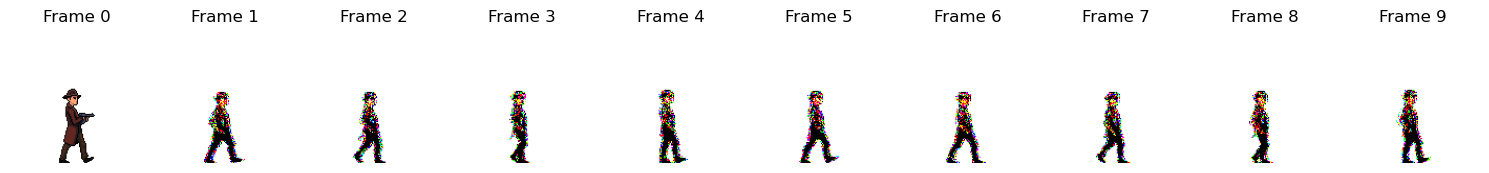

In [11]:
def display_predicted_frames(predicted_frames):
    """
    Display predicted frames using Matplotlib.

    Parameters:
    predicted_frames (numpy array): Array of predicted frames.
    """
    num_frames = predicted_frames.shape[0]

    # Create a figure to display the frames
    plt.figure(figsize=(15, 5))

    for i in range(num_frames):
        plt.subplot(1, num_frames, i + 1)  # Create a subplot for each frame
        plt.imshow(predicted_frames[i])  # Display the frame
        plt.axis('off')  # Hide the axes
        plt.title(f'Frame {i}')  # Optional: add title to each frame

    plt.tight_layout()  # Adjust subplots to fit in to the figure area.
    plt.show()  # Show the plot

display_predicted_frames(refine_train[3])

In [12]:
# def animate_frames(predicted_frames):
#     """
#     Create and display an animation from predicted frames in Jupyter Notebook.
    
#     Parameters:
#     predicted_frames (numpy array): Array of predicted frames, expected shape (num_frames, 128, 128, 3).
#     """
#     num_frames = predicted_frames.shape[0]

#     # Create a figure
#     fig, ax = plt.subplots()

#     # Display the first frame initially
#     img = ax.imshow(predicted_frames[0], animated=True)
#     ax.axis('off')  # Hide the axis for visual appeal

#     # Update function for the animation
#     def update(frame_num):
#         img.set_array(predicted_frames[frame_num])  # Update the image data with the new frame
#         return [img]

#     # Create the animation: FuncAnimation creates a new image every interval
#     ani = FuncAnimation(
#         fig, update, frames=num_frames, interval=200, blit=True  # interval sets the frame display time (in ms)
#     )

#     # Display the animation in Jupyter
#     plt.close(fig)  # Close the figure to prevent a static image from being displayed
#     return HTML(ani.to_jshtml())  # Display the animation in HTML format


# animate_frames(merged_frames)

In [13]:
# # saving gif file

# def animate_frames(predicted_frames, save_path=None, fps=5):
#     """
#     Create, display, and optionally save an animation from predicted frames in Jupyter Notebook.
    
#     Parameters:
#     predicted_frames (numpy array): Array of predicted frames, expected shape (num_frames, 128, 128, 3).
#     save_path (str, optional): Path to save the animation (supports formats like .mp4 or .gif).
#     fps (int, optional): Frames per second for the animation. Default is 5 fps.
#     """
#     num_frames = predicted_frames.shape[0]

#     # Create a figure
#     fig, ax = plt.subplots()

#     # Display the first frame initially
#     img = ax.imshow(predicted_frames[0], animated=True)
#     ax.axis('off')  # Hide the axis for visual appeal

#     # Update function for the animation
#     def update(frame_num):
#         img.set_array(predicted_frames[frame_num])  # Update the image data with the new frame
#         return [img]

#     # Create the animation: FuncAnimation creates a new image every interval
#     ani = FuncAnimation(
#         fig, update, frames=num_frames, interval=1000//fps, blit=True  # interval in ms
#     )

#     if save_path:
#         # Save the animation
#         if save_path.endswith(".mp4"):
#             ani.save(save_path, writer="ffmpeg", fps=fps)
#         elif save_path.endswith(".gif"):
#             ani.save(save_path, writer="pillow", fps=fps)
#         print(f"Animation saved to {save_path}")
    
#     # Display the animation in Jupyter
#     plt.close(fig)  # Close the figure to prevent a static image from being displayed
#     return HTML(ani.to_jshtml())

# animate_frames(merged_frames, '/Users/lofichill/Desktop/NIPA/a-yo-image/initial-experiments/tomato/output/Stride_Conv.gif', fps=5)

In [32]:
def refinement_model(input_shape, output_frames):
    # Encoder
    input = layers.Input(shape=(491520,), name='input')  # Flattened input

    # dense1 = layers.Dense(1024, activation='relu')(input)
    # dropout1 = layers.Dropout(0.3)(dense1)

    # Dense layer
    dense2 = layers.Dense(3, activation='relu')(input)

    # Decoder: Dense layer to predict frames in a single flattened vector
    decoder_output = layers.Dense(491520, activation='sigmoid')(dense2)

    # Reshape the decoder output to match the target shape (batch_size, output_frames, 491520 / output_frames)
    decoder_output_reshaped = layers.Reshape((output_frames, 491520 // output_frames))(decoder_output)
    
    # Create the model
    model = models.Model(input, decoder_output_reshaped, name='frame_predictor_model')
    
    # Compile the model
    model.compile(optimizer='adam', loss=mse_rgb, metrics=['mae'])
    
    return model

In [33]:
# Define input shape as (frames, height, width, channels)
input_shape = 491520  # Example: sequence of frames, each 128x128 with 3 channels (RGB)
output_frames = 10  # Example: number of frames

# Build the refinement model
refinement_model = refinement_model(input_shape, output_frames)
refinement_model.summary()

Model: "frame_predictor_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 491520)]          0         
                                                                 
 dense_3 (Dense)             (None, 3)                 1474563   
                                                                 
 dense_4 (Dense)             (None, 491520)            1966080   
                                                                 
 reshape_1 (Reshape)         (None, 10, 49152)         0         
                                                                 
Total params: 3440643 (13.13 MB)
Trainable params: 3440643 (13.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
def process_sprite_data_2(sprite_sheet_paths, num_frames):
    """
    Processes sprite sheets and returns animation data without saving individual images.
    
    Parameters:
    sprite_sheet_paths (list): List of paths to the sprite sheet images.
    num_frames (int): Total number of frames (sprites) in the sprite sheet.
    
    Returns:
    Y (numpy array): Array of flattened frames from each animation sequence with shape (6, 10 * 128 * 128 * 3).
    """
    # Initialize a list for output (Y) frames
    Y = []
    
    # Process each sprite sheet in the provided paths
    for sprite_sheet_path in sprite_sheet_paths:
        sprite_sheet = Image.open(sprite_sheet_path)
        
        # Get sprite sheet dimensions
        sheet_width, sheet_height = sprite_sheet.size
        frame_width = sheet_width // num_frames  # Calculate frame width
        frame_height = sheet_height  # Height of each frame
        
        # Initialize a list to store all frames in a flattened format for this sprite sheet
        current_sprite_frames = []
        
        # Loop through each frame in the sprite sheet
        for frame_num in range(num_frames):
            # Crop the sprite from the sprite sheet
            left = frame_num * frame_width
            upper = 0
            right = left + frame_width
            lower = frame_height
            
            frame = sprite_sheet.crop((left, upper, right, lower))
            frame = frame.convert('RGB').resize((128, 128))  # Resize to 128x128 and convert to RGB
            
            # Normalize pixel values and flatten each frame to (128 * 128 * 3,)
            frame_array = np.array(frame) / 255.0
            frame_flattened = frame_array.flatten()
            
            # Append the flattened frame to the list of frames for this sprite sheet
            current_sprite_frames.append(frame_flattened)
        
        # Stack frames for this sprite sheet to shape (10, 128*128*3), then flatten to (1, 10 * 128 * 128 * 3)
        current_sprite_frames = np.array(current_sprite_frames).reshape(1, -1)
        
        # Append the flattened frames for the current sprite sheet
        Y.append(current_sprite_frames)
    
    # Concatenate all sprite sheets along the first dimension to get final shape (6, 10 * 128 * 128 * 3)
    Y = np.concatenate(Y, axis=0)
    
    return Y

# Example usage
# sprite_sheet_paths = ['path_to_sheet1.png', 'path_to_sheet2.png', 'path_to_sheet3.png', 
#                        'path_to_sheet4.png', 'path_to_sheet5.png', 'path_to_sheet6.png']
# processed_data = process_sprite_data_2(sprite_sheet_paths, num_frames=10)


In [17]:
sprite_sheet_paths = ['/Users/lofichill/Desktop/NIPA/a-yo-image/initial-experiments/tomato/image folder/City_men_1_10f/Walk.png',
                      '/Users/lofichill/Desktop/NIPA/a-yo-image/initial-experiments/tomato/image folder/City_men_2_10f/Walk.png',
                      '/Users/lofichill/Desktop/NIPA/a-yo-image/initial-experiments/tomato/image folder/City_men_3_10f/Walk.png',
                      '/Users/lofichill/Desktop/NIPA/a-yo-image/initial-experiments/tomato/image folder/Gangsters_1_10f/Walk.png',
                      '/Users/lofichill/Desktop/NIPA/a-yo-image/initial-experiments/tomato/image folder/Gangsters_2_10f/Walk.png',
                      '/Users/lofichill/Desktop/NIPA/a-yo-image/initial-experiments/tomato/image folder/Gangsters_3_10f/Walk.png'
                     ] 
num_frames = 10  # Number of frames in the sprite sheet
Y = process_sprite_data_2(sprite_sheet_paths, num_frames)

print(f"Y shape: {Y.shape}")  # Should be (num_sequences, 9, 128, 128, 3)

Y shape: (6, 491520)


In [28]:
refine_train = refine_train.reshape(6, 10*128*128*3)
Y = Y.reshape(6, 10, 49152)

In [29]:
print(refine_train.shape, Y.shape)

(6, 491520) (6, 10, 49152)


In [34]:
refinement_model.fit(refine_train, Y, epochs=20, batch_size=32)

Epoch 1/20


2024-10-25 15:44:36.866559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.2441 - mae: 0.4923
Epoch 2/20
1/1 [==============================] - 0s 40ms/step - loss: 0.2453 - mae: 0.4929
Epoch 3/20
1/1 [==============================] - 0s 37ms/step - loss: 0.2164 - mae: 0.4453
Epoch 4/20
1/1 [==============================] - 0s 36ms/step - loss: 0.1608 - mae: 0.3502
Epoch 5/20
1/1 [==============================] - 0s 39ms/step - loss: 0.1017 - mae: 0.2708
Epoch 6/20
1/1 [==============================] - 0s 41ms/step - loss: 0.0474 - mae: 0.1530
Epoch 7/20
1/1 [==============================] - 0s 42ms/step - loss: 0.0176 - mae: 0.0681
Epoch 8/20
1/1 [==============================] - 0s 37ms/step - loss: 0.0110 - mae: 0.0309
Epoch 9/20
1/1 [==============================] - 0s 41ms/step - loss: 0.0107 - mae: 0.0220
Epoch 10/20
1/1 [==============================] - 0s 43ms/step - loss: 0.0106 - mae: 0.0206
Epoch 11/20
1/1 [==============================] - 0s 37ms/step - loss: 0.0106 - mae: 0.0204

In [35]:
# Should input (None, n of frames, 128, 128, 3)
refined_frames = refinement_model.predict(np.expand_dims(refine_train[0], axis=0))  # Add batch dimension

# Post-process the predicted frames if necessary
refined_frames = refined_frames.squeeze()  # Remove the batch dimension if needed
print(f"Refined frames shape: {refined_frames.shape}")  # Should be (10, 128, 128, 3)

# Check the range of the output values
print(f"Output range: min={refined_frames.min()}, max={refined_frames.max()}")

for i in range(refined_frames.shape[0]):
    (refined_frames[i] * 255).astype(np.uint8)  # Convert back to [0, 255]

1/1 [==============================] - 0s 42ms/step
Refined frames shape: (10, 49152)
Output range: min=5.8774891996806e-15, max=1.0


2024-10-25 15:44:45.123435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [38]:
refined_frames = refined_frames.reshape(10, 128, 128, 3)

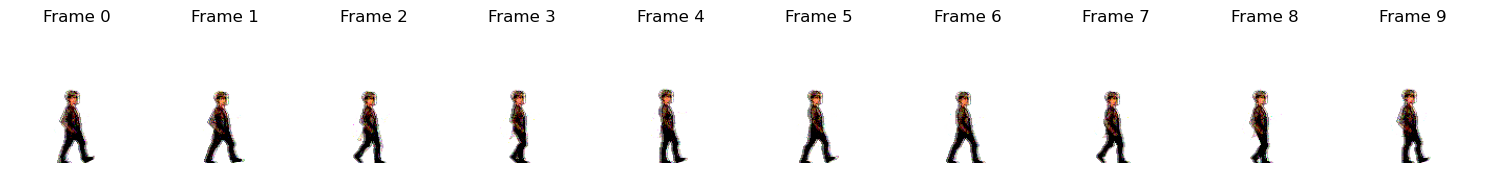

In [39]:
display_predicted_frames(refined_frames)

In [40]:
def animate_frames(predicted_frames):
    """
    Create and display an animation from predicted frames in Jupyter Notebook.
    
    Parameters:
    predicted_frames (numpy array): Array of predicted frames, expected shape (num_frames, 128, 128, 3).
    """
    num_frames = predicted_frames.shape[0]

    # Create a figure
    fig, ax = plt.subplots()

    # Display the first frame initially
    img = ax.imshow(predicted_frames[0], animated=True)
    ax.axis('off')  # Hide the axis for visual appeal

    # Update function for the animation
    def update(frame_num):
        img.set_array(predicted_frames[frame_num])  # Update the image data with the new frame
        return [img]

    # Create the animation: FuncAnimation creates a new image every interval
    ani = FuncAnimation(
        fig, update, frames=num_frames, interval=200, blit=True  # interval sets the frame display time (in ms)
    )

    # Display the animation in Jupyter
    plt.close(fig)  # Close the figure to prevent a static image from being displayed
    return HTML(ani.to_jshtml())  # Display the animation in HTML format

animate_frames(refined_frames)

In [42]:
# saving gif file

def animate_frames(predicted_frames, save_path=None, fps=5):
    """
    Create, display, and optionally save an animation from predicted frames in Jupyter Notebook.
    
    Parameters:
    predicted_frames (numpy array): Array of predicted frames, expected shape (num_frames, 128, 128, 3).
    save_path (str, optional): Path to save the animation (supports formats like .mp4 or .gif).
    fps (int, optional): Frames per second for the animation. Default is 5 fps.
    """
    num_frames = predicted_frames.shape[0]

    # Create a figure
    fig, ax = plt.subplots()

    # Display the first frame initially
    img = ax.imshow(predicted_frames[0], animated=True)
    ax.axis('off')  # Hide the axis for visual appeal

    # Update function for the animation
    def update(frame_num):
        img.set_array(predicted_frames[frame_num])  # Update the image data with the new frame
        return [img]

    # Create the animation: FuncAnimation creates a new image every interval
    ani = FuncAnimation(
        fig, update, frames=num_frames, interval=1000//fps, blit=True  # interval in ms
    )

    if save_path:
        # Save the animation
        if save_path.endswith(".mp4"):
            ani.save(save_path, writer="ffmpeg", fps=fps)
        elif save_path.endswith(".gif"):
            ani.save(save_path, writer="pillow", fps=fps)
        print(f"Animation saved to {save_path}")
    
    # Display the animation in Jupyter
    plt.close(fig)  # Close the figure to prevent a static image from being displayed
    return HTML(ani.to_jshtml())

animate_frames(refined_frames, '/Users/lofichill/Desktop/NIPA/a-yo-image/initial-experiments/tomato/output/refinement.gif', fps=5)

Animation saved to /Users/lofichill/Desktop/NIPA/a-yo-image/initial-experiments/tomato/output/refinement.gif
